In [29]:
from astropy.io import fits
import pylab as plt
import numpy as np
from scipy.optimize import curve_fit

plt.style.use('seaborn-whitegrid')

In [30]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

In [31]:
plt.rc('font', **font)

In [32]:
#plt.style.available

Funcitons used throughout the program

In [33]:
def frequency(hdu, data):
    '''
    Function that generates a frequency array the length of data
    
    Parameter
    ---------
    
    data: the data we are trying to get the frquency array for
    
    Output
    ---------
    freq: frequency array with the given sampling frequency of 96 MHz
    '''
    nu_samp = hdu[0].header['SAMPRATE']
    
    freq = np.fft.fftfreq(len(data), d = 1/nu_samp)
    
    return freq

In [34]:
def average_spectrum(hdu, N):
    
    '''
    Function that calculates the average power spectrum from the N samples that we took
    We do this to reduce the noise in the power spectrum
    
    Parameters
    ----------
    
    hdu: the hdu for the data we are tyring to find the average power spectrum for
    N: the number of integrated samples we took
    
    Output
    ----------
    
    avg: this is the averaged power spectrum over the N samples
    '''
    
    #this is a counter variable for the while loop
    M = 1
    
    #variable that will hold the averaged power spectrum for one polarization and another
    data = 0
    data_pol = 0
    
    #while loop that does the summation
    while M <= N:
        
        data += hdu[M].data['auto0_real']
        data_pol += hdu[M].data['auto1_real']
        M+=1
    
    #calculates the average of each power spectrum
    avg = data/N
    avg_pol = data_pol/N
    
    
    return avg, avg_pol

In [35]:
def Num_Spec(hdu):
    
    '''
    Function that returns the number of spectrums we have in our FITS file
    
    Parameter
    ----------
    hdu: the hdu for the data we want to get
    
    Output
    ----------
    The number of samples we used 
    '''
    
    N = hdu1[0].header['NSPEC']
    
    return N

In [36]:
def fit(data, freq):
    
    '''
    Function to fit the data we collected form the telescope and fit a quadratic to the data
    
    We use scipy's curve_fit to optimize the parameters for the quadratic
    
    Parameter
    -----------
    
    data: This is the power spectrum data
    freq: the frequency array for the data
    
    Output
    -----------
    outputs the best fit line as an array 
    
    '''
    
    #making a model for which we are trying to optimize in this case this is a quadratic equation
    def model(x, a, b, c):
        return a*x**2 + b*x + c
    
    #using curve_fit to get the optimized values for a, b, c in the quadratic equation
    param, covar = curve_fit(model, np.fft.fftshift(freq), data)
    
    return model(np.fft.fftshift(freq), param[0], param[1], param[2])

In [37]:
def Gain(s_cal, s_cold):
    
    '''
    Function that calculates the gain for the telescope
    
    Parameters
    ------------
    s_cal: calibrated data, this should be the one with the noise added
    s_cold: non-calibrated data just the telescope pointing in an arbitrary direction
    
    Ouptut
    ------------
    G: the gain calculated for the telescope which we multiply all our power spectrum by
    '''

    #the temperature we used for the calibration we we use as 30K for the T_cal and T_cold as space 2.73K       
    T_cal = 30
    T_cold = 2.73

    #getting the difference
    diff = s_cal-s_cold

    #calculating the Gain
    G = ((T_cal - T_cold)/(np.sum(diff))) * np.sum(s_cold)
    
    return G

In [38]:
def T_power(line, G):
    
    '''
    Function that calculates the intensity of the power spectrum given the spectrum and gain value
    
    Parameter
    -----------
    line: the spectrum we will multiply by the gain
    G: the gain of the telescope
    
    Output
    -----------
    power: the final calibrated intesnity of the object in units of temperature
    '''
    #getting the final intensity power
    power = line * G

    return power

Working on cold sky data. For this we turned on the noise for the telescope pointed it at a random direction and used this to calculate the Gain in the functions below. We also have data with the noise turned off. 

---

Opening the files: Calibration Purposes

In [39]:
hdu1 = fits.open('noise_off.fits')#Noise Off Data
hdu2 = fits.open('noise_on.fits') #Noise On Data

Getting the data to see how it looks like.

In [40]:
data1 = hdu1[1].data['auto0_real']
data2 =  hdu2[1].data['auto0_real']

In [41]:
freq1 = frequency(hdu1, data1)
freq2 = frequency(hdu2, data2)

In [42]:
hdr = hdu1[0].header

In [43]:
#print(repr(hdr))

In [44]:
cal_avg, cal_avg_pol = average_spectrum(hdu2, 100)
cold_avg, cold_avg_pol = average_spectrum(hdu1, 100)

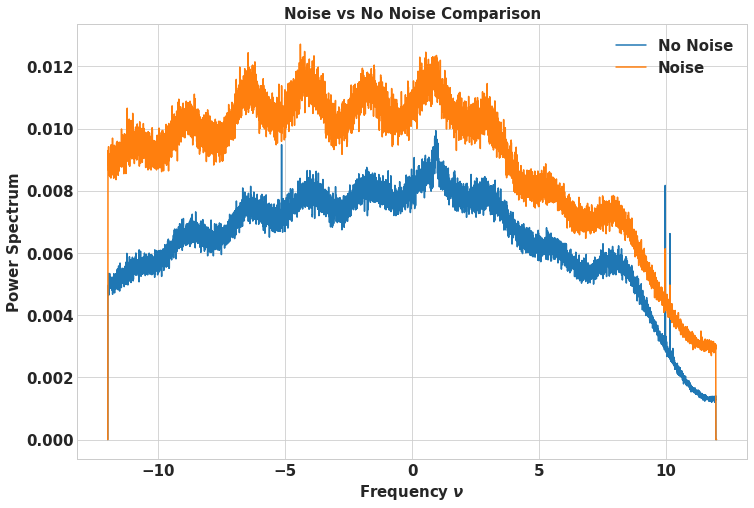

In [45]:
plt.figure(figsize = (12,8))
plt.title('Noise vs No Noise Comparison', fontsize = 15, weight = 'semibold')
plt.xlabel(r'Frequency $\nu$', fontsize = 15, weight = 'semibold')
plt.ylabel(r'Power Spectrum', fontsize = 15, weight = 'semibold')
plt.plot(np.fft.fftshift(freq1)/1e6, data1, label = 'No Noise')
plt.plot(np.fft.fftshift(freq2)/1e6, data2, label = 'Noise')
plt.legend()
plt.savefig('Noise_Comparison.jpg')

---

Cassiopea data:

Cassiopea is our first attempt o point it at Cassiopea

In [46]:
hdu_cass = fits.open('cassiopea.fits')

In [47]:
hdr_cass = hdu_cass[0].header

In [48]:
#print(repr(hdr_cass))

In [49]:
data_cass100 = hdu_cass[100].data['auto0_real']
data_cass1 = hdu_cass[1].data['auto0_real']

In [50]:
avg_spec, avg_spec_pol = average_spectrum(hdu_cass, 100)

In [51]:
freq_cass = frequency(hdu_cass, avg_spec)

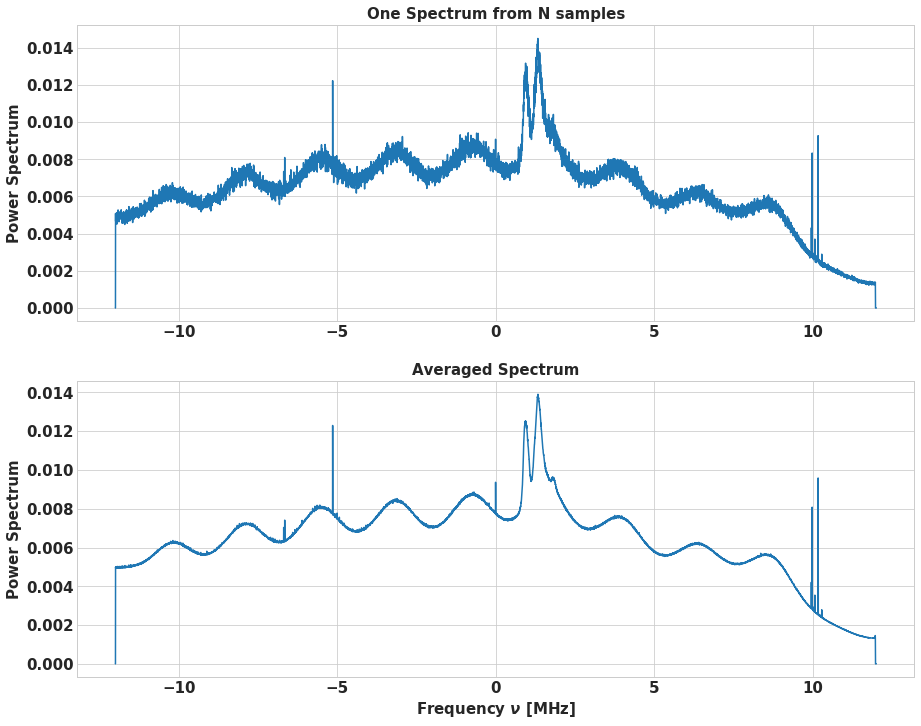

In [52]:
fig = plt.figure(figsize = (15,12))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.set_title('One Spectrum from N samples', fontsize = 15, weight = 'semibold')
#ax1.set_xlabel(r'Frequency $\nu$ [MHz]')
ax1.set_ylabel('Power Spectrum', fontsize = 15, weight = 'semibold')

ax1.plot(np.fft.fftshift(freq_cass)/1e6, data_cass1)

ax2.set_title('Averaged Spectrum', fontsize = 15, weight = 'semibold')
ax2.set_xlabel(r'Frequency $\nu$ [MHz]', fontsize = 15, weight = 'semibold')
ax2.set_ylabel('Power Spectrum', fontsize = 15, weight = 'semibold')
ax2.plot(np.fft.fftshift(freq_cass)/1e6, avg_spec)

plt.savefig('Smoothing_Function.jpg')

---

Galactic Data

In [54]:
hdu_center = fits.open('cassiopea1.fits')

In [55]:
hdr1 = hdu_center[0].header
#print(repr(hdr1))

In [56]:
avg_center, avg_center_pol = average_spectrum(hdu_center, 100)

In [57]:
freq_center = frequency(hdu_center, avg_center)

Text(0.5, 0, 'Frequency [MHz]')

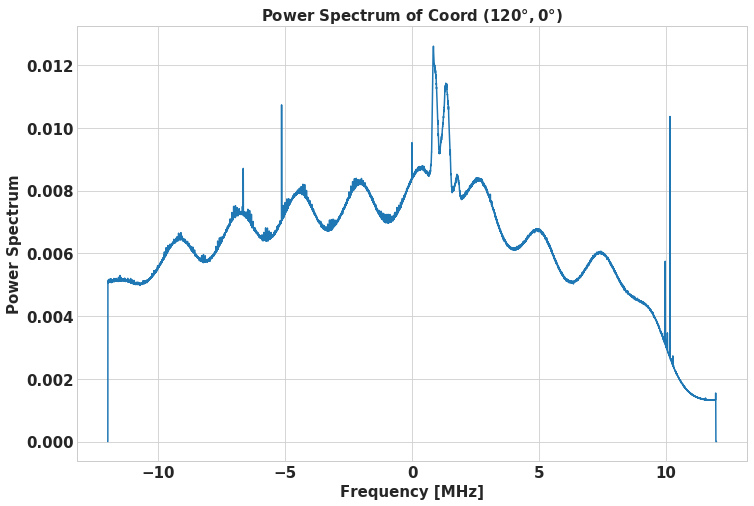

In [58]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fftshift(freq_center)/1e6, avg_center)
#plt.plot(np.fft.fftshift(freq)/1e6, base_data, label = 'base')
#plt.plot(avg_spec, label = 'cass')
plt.title(r'Power Spectrum of Coord ($120\degree, 0\degree$)', fontsize = 15, weight = 'semibold')
plt.ylabel('Power Spectrum', fontsize = 15, weight = 'semibold')
plt.xlabel('Frequency [MHz]', fontsize = 15, weight = 'semibold')
#plt.legend()

Offset data for which we set the LO to 625MHz

In [59]:
hdu_base = fits.open('cassiopea2.fits')

In [60]:
base_data,base_data_pol = average_spectrum(hdu_base, 100)

In [64]:
freq_base = frequency(hdu_base, base_data)

(0, 0.015)

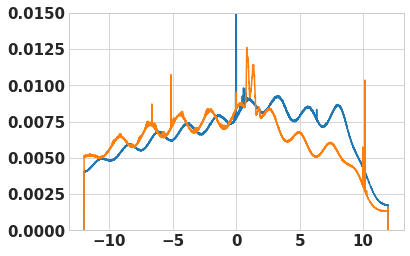

In [65]:
plt.plot(np.fft.fftshift(freq_base)/1e6, base_data)
plt.plot(np.fft.fftshift(freq_center)/1e6, avg_center)
plt.ylim(0,.015)

In [67]:
fitline = fit(avg_center, freq_center)

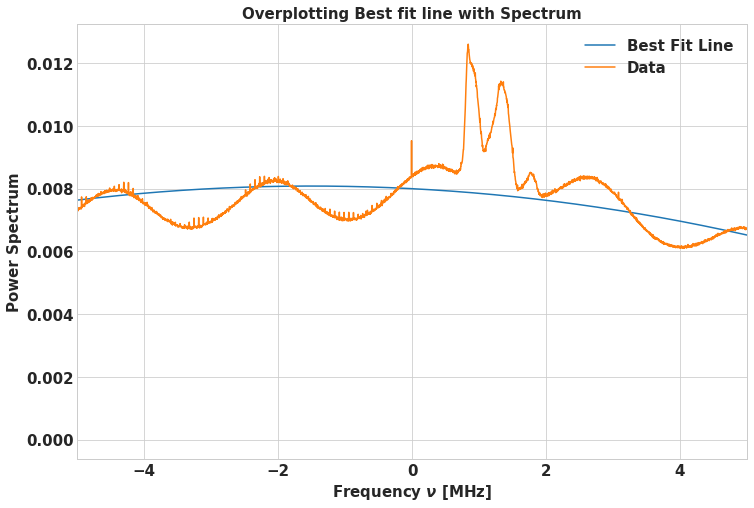

In [68]:
plt.figure(figsize = (12,8))
plt.title('Overplotting Best fit line with Spectrum', fontsize = 15, weight = 'semibold')
plt.xlabel(r'Frequency $\nu$ [MHz]', fontsize = 15, weight = 'semibold')
plt.ylabel('Power Spectrum', fontsize = 15, weight = 'semibold')
plt.plot(np.fft.fftshift(freq_center)/1e6, fitline, label = 'Best Fit Line')
plt.plot(np.fft.fftshift(freq_center)/1e6, avg_center, label = 'Data')
plt.xlim(-5,5)
plt.legend()
plt.savefig('Best_Fit.jpg')

In [70]:
G = Gain(cal_avg, cold_avg)

In [71]:
#calculating the difference bewtween Power Spectrum and best fit line
spec = (avg_center - fitline)*G

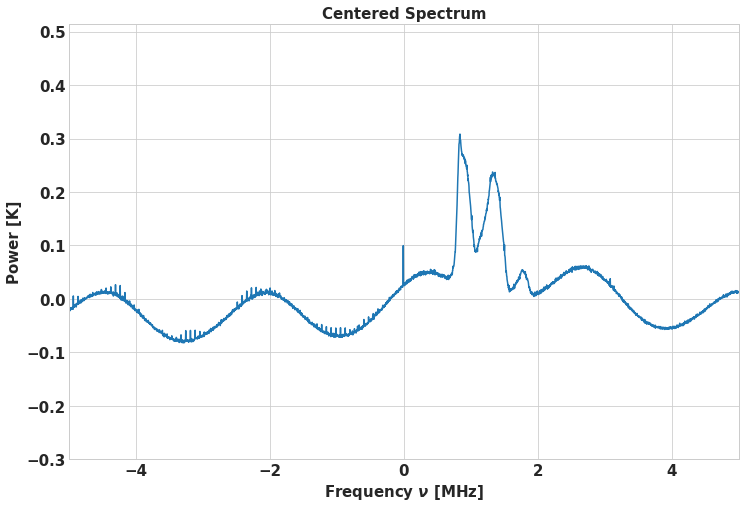

In [72]:
plt.figure(figsize = (12, 8))
plt.title('Centered Spectrum', fontsize = 15, weight = 'semibold')
plt.xlabel(r'Frequency $\nu$ [MHz]', fontsize = 15, weight = 'semibold')
plt.ylabel('Power [K]', fontsize = 15, weight = 'semibold')
plt.xlim(-5,5)
plt.plot(np.fft.fftshift(freq_center)/1e6, spec)
plt.savefig('Final_Centered_Data.jpg')

---

NameError: name 'diff' is not defined